In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import matplotlib.patches as patches
#import seaborn as sns
from collections import Counter
import os
import random
import xml.etree.ElementTree as ET
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

import sys
import torch.optim as optim
from tqdm.notebook import tqdm

#import xmltodict

In [2]:
device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def xml_transform(xml_path):
    xml = ET.parse(xml_path)
    root = xml.getroot()
    img_name = root[1].text
    labels, boxes = [], [] 
    
    for obj in root.iter('object'):
        label = obj[0].text
        labels.append(label)
        box = [int(coord.text) for coord in obj[4]]
        boxes.append(box)
    target = {'boxes' : torch.as_tensor(boxes, dtype=torch.float32),
              'labels' : labels}
    return img_name, target

def count_classes(path_annotations):
    target_list = []
    xml_list = [os.path.join(path_annotations, file) for file in os.listdir(path_annotations)]
    for xml in xml_list:
        _, target = xml_transform(xml)
        target_list += target['labels']
    return Counter(target_list) 
    

In [5]:
path_annotations = "/content/drive/MyDrive/birds/annotations/" 
images_dir = "/content/drive/MyDrive/birds/"

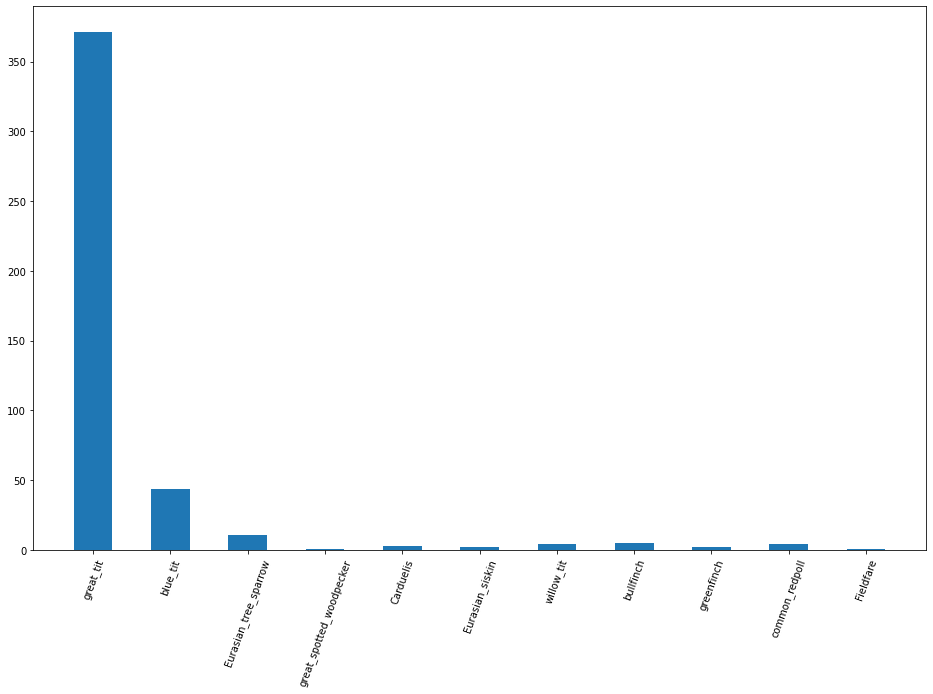

In [6]:
#class distribution

labels, values = zip(*count_classes(path_annotations).items())

labels_dict = { i+1:label for i,label in enumerate(labels)}# labels dictionary
n_classes = len(labels_dict)  # number of classes

indexes = np.arange(len(labels))
width = 0.5
plt.figure(figsize = (16,10))
plt.bar(indexes, values, width, align='edge')
plt.xticks(indexes + width * 0.5, labels, rotation=70)
plt.show()

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [8]:
def train_val_split(path_annotations,val_size=.25, seed=773):
    random.seed(seed)
    path_list = [os.path.join(path_annotations,path) for path in os.listdir(path_annotations)]
    val_size = int(len(path_list)*val_size)
    val_paths = random.sample(path_list,val_size)
    train_paths = list(set(path_list) - set(val_paths)) 
    return train_paths, val_paths
    

In [9]:
train_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])

val_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])

In [10]:
class BirdsDataset(torch.utils.data.Dataset):
    def __init__(self,transform,annotation_paths,images_dir):
        self.transform = transform
        self.annotation_paths = annotation_paths
        self.images_dir = images_dir
        
    def __len__(self):
        return len(self.annotation_paths)
    
    def __getitem__(self,idx):
        path = self.annotation_paths[idx]
        img_name, target = xml_transform(path)
        target['labels'] = [list(labels_dict.keys())[list(labels_dict.values()).index(label)] for label in target['labels']]
        target['labels']  = torch.as_tensor(target['labels'], dtype=torch.int64) 
        img_path = os.path.join(self.images_dir,img_name)
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        
        return img, target
        
        
        

In [11]:
batch_size = 4
val_size = 0.25
train_ann_path, val_ann_path = train_val_split(path_annotations,val_size=val_size,seed=779)

train_dataset = BirdsDataset(transform=train_transform,
                            annotation_paths = train_ann_path,
                            images_dir  = images_dir)

val_dataset = BirdsDataset(transform=val_transform,
                            annotation_paths = val_ann_path,
                            images_dir  = images_dir)

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size,shuffle = True,
                                            collate_fn=collate_fn)

val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True,
                                            collate_fn=collate_fn)

dataloaders = {'train': train_batch_gen,
               'val': val_batch_gen}

dataset_sizes = {'train' : len(train_dataset),
                 'val' : len(val_dataset)}

In [12]:
def plot_detection(img, info, with_text=False, conf_lvl=0.3, swap=True):
    fig, ax = plt.subplots()
    #color_dict = {3: 'red', 1: 'green', 2: 'yellow'}
    if swap:
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)
        img = np.clip(img, 0, 1)
    ax.imshow(img)
    flag = False
    if 'scores' in info.keys():
        mask = info['scores'] >= conf_lvl
        confidences = info['scores'][mask]
        boxes = info['boxes'][mask]
        labels = info['labels'][mask]
        
        flag = True
    else:
        
        boxes = info['boxes']
        labels = info['labels']

    
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        height = y_max - y_min
        width = x_max - x_min
        
        label = labels[i] #labels_dict [int(labels[i])]
        #color = color_dict[int(labels[i])]
        rect = patches.Rectangle((x_min, y_min), width, height,
                                 linewidth=2, edgecolor="red",
                                 facecolor='none')
        ax.add_patch(rect)
        if with_text:
            if flag:
                text = '{} {:.0f}%'.format(label, confidences[i]*100)
            else:
                text = '{}'.format(label)
            ax.text(x_min, y_min, text,
                    bbox=dict(facecolor='white', alpha=0.5))
    plt.show()


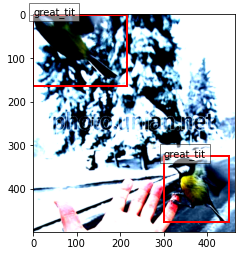

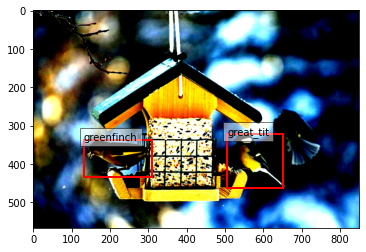

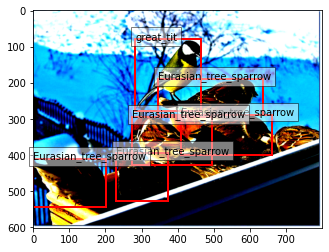

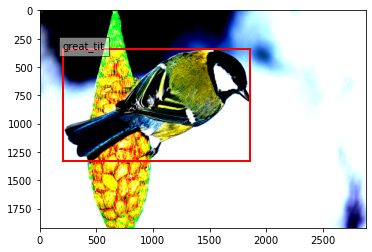

In [47]:
imgs, boxes= next(iter(val_batch_gen))
for img, info in zip(imgs, boxes):
    plot_detection(img, info, with_text=True)


## Model and training


In [13]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#load Faster R-CNN pre-trained on COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#Change the classifier head with a new one:
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = n_classes+1 #(n_classes + background)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

Starting epoch 0


  0%|          | 0/58 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/19 [00:00<?, ?it/s]

Starting epoch 1


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

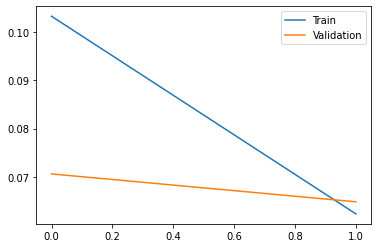

Starting epoch 2


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

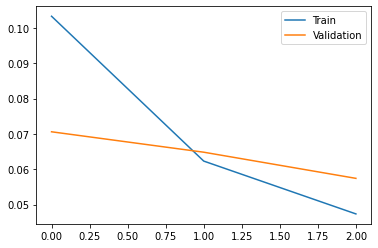

Starting epoch 3


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

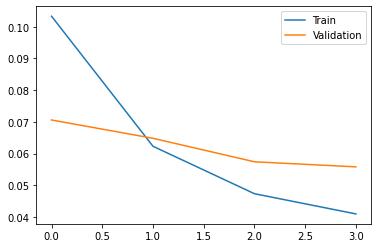

Starting epoch 4


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

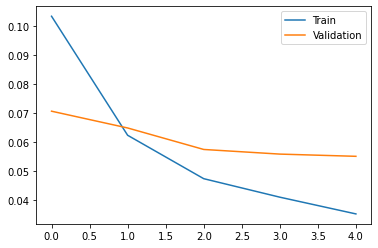

Starting epoch 5


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

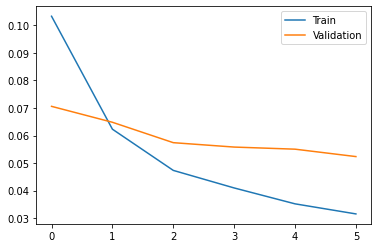

In [14]:
number_epochs = 6   #TODO: Choose
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9)#TODO: Choose, momentum=#TODO: Choose)

train_loss = []
val_loss = []

for epoch in range(number_epochs):
  print(f"Starting epoch {epoch}")

  if epoch > 0:
    plt.figure()

  model.train()
  train_loss.append(0)
  for images, labels in tqdm(train_batch_gen):
    images = list(image.to(device) for image in images)
    labels = [{k: v.to(device) for k, v in t.items()} for t in labels]
    #print(len(images), images[0].shape, images[1].shape)

    loss_dict = model(images, labels)

    #print(type(loss_dict), len(loss_dict), loss_dict, )
    #print(loss_dict.values() )

    losses = sum(loss for loss in loss_dict.values())
    optimizer.zero_grad()
    losses.backward()
    optimizer.step() 

    train_loss[epoch] += losses.cpu().data
  train_loss[epoch] /= len(train_dataset)

  if epoch > 0:
    train_plt, = plt.plot(train_loss, label = 'Train')

  #TODO: compute the loss on the validation set and fill val_loss[epoch]
  #model.eval()
  val_loss.append(0)
  with torch.no_grad():
    for images, labels in tqdm(val_batch_gen):
      images = list(image.to(device) for image in images)
      labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

      loss_dict = model(images, labels)
      #print(type(loss_dict), len(loss_dict), loss_dict)
      losses = sum(loss for loss in loss_dict.values())
      val_loss[epoch] += losses.cpu().data
    val_loss[epoch] /= len(val_dataset)
    

  if epoch > 0:
    val_plt, = plt.plot(val_loss, label = 'Validation')
    plt.legend(handles=[train_plt, val_plt])
    plt.show()

In [15]:
next(iter(train_batch_gen))

((tensor([[[-0.3883, -0.3883, -0.4054,  ..., -1.6042, -1.6213, -1.6384],
           [-0.3712, -0.3712, -0.3883,  ..., -1.6042, -1.6042, -1.6213],
           [-0.3883, -0.3883, -0.4054,  ..., -1.6042, -1.5870, -1.6042],
           ...,
           [-1.7069, -1.7240, -1.7240,  ..., -1.5699, -1.5870, -1.6042],
           [-1.7069, -1.7240, -1.7240,  ..., -1.5528, -1.5699, -1.5870],
           [-1.6555, -1.6898, -1.7069,  ..., -1.5699, -1.5870, -1.6042]],
  
          [[-0.1275, -0.1275, -0.1450,  ..., -1.2829, -1.3004, -1.3179],
           [-0.1099, -0.1099, -0.1275,  ..., -1.2829, -1.2829, -1.3004],
           [-0.1275, -0.1275, -0.1450,  ..., -1.2829, -1.2654, -1.2829],
           ...,
           [-1.4580, -1.4755, -1.4755,  ..., -1.1604, -1.1779, -1.1954],
           [-1.4580, -1.4755, -1.4755,  ..., -1.1429, -1.1604, -1.1779],
           [-1.4055, -1.4405, -1.4580,  ..., -1.1604, -1.1779, -1.1954]],
  
          [[-0.7238, -0.7238, -0.7413,  ..., -1.3687, -1.3861, -1.4036],
           

In [20]:
torch.save(model.state_dict(), '/content/drive/MyDrive/birds/model_g400_6ep.pt')

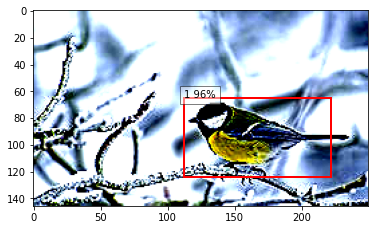

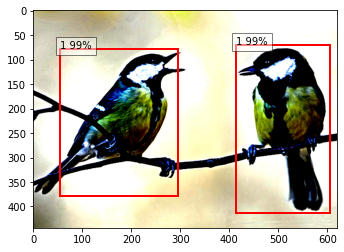

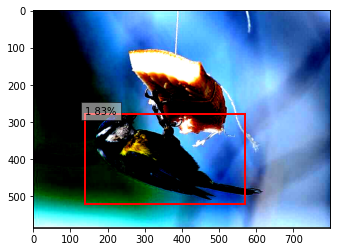

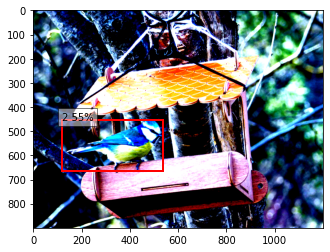

In [19]:
model.eval()
imgs, targets = next(iter(dataloaders['val']))
inputs = list(img.to(device) for img in imgs)
targets = [{k:v.to(device) for k,v in t.items()} for t in targets] 
preds = model(inputs)

for img, info in zip(imgs, preds):
    plot_detection(img, info, conf_lvl=0.5, with_text=True)

In [ ]:
def xml_transform(xml_path):
    xml = ET.parse(xml_path)
    root = xml.getroot()
    img_name = root[1].text
    labels, boxes = [], [] 
    
    for obj in root.iter('object'):
        label = obj[0].text
        label = list(labels_dict.keys())[list(labels_dict.values()).index(label)]
        labels.append(label)
        box = [int(coord.text) for coord in obj[4]]
        boxes.append(box)
    labels = torch.from_numpy(np.asarray(labels))
    target = {'boxes' : torch.as_tensor(boxes, dtype=torch.float32),
              'labels' : labels}
    return img_name, target

In [ ]:
 img = Image.open(images_dir+"синицы на снегу_57.jpg").convert('RGB')

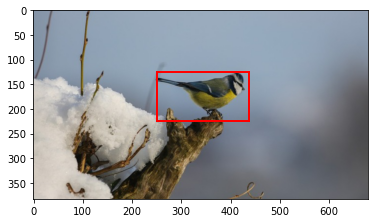

In [ ]:
fig, ax = plt.subplots()
plt.imshow(img)

x_min, y_min, x_max, y_max = [251., 124., 437., 225.]
height= y_max - y_min
width = x_max - x_min
        #label = idx_label_dict[int(labels[i])]
        #color = color_dict[int(labels[i])]
rect = patches.Rectangle((x_min, y_min), width, height,
                                 linewidth=2, edgecolor="red",
                                 facecolor='none')
ax.add_patch(rect)

In [ ]:
device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")

device(type='cpu')

In [ ]:
torch.cuda.is_available ()

False

In [ ]:
def plot_batch(imgs, targets, preds=None):
    
    """
    Plot images of one batch
    """
    fig, axs = plt.subplots(nrows=1,
                            ncols=len(imgs),
                            figsize=(12, 8))
    
    for i, (img, target) in enumerate(zip(imgs, targets)):
        #text = [key for key, val in label_idx_dict.items() if val==target][0]
        if preds is not None:
            pred = [key for key, val in label_idx_dict.items() if val==preds[i]][0]
            text = 'True: {},\n Predicted: {}'.format(text, pred)
        img = img.numpy().transpose((1, 2, 0))
        axs[i].imshow(img)
        #axs[i].set_title(text)
        axs[i].axis('off')
    plt.show()

In [ ]:
imgs, boxes = next(iter(val_batch_gen))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


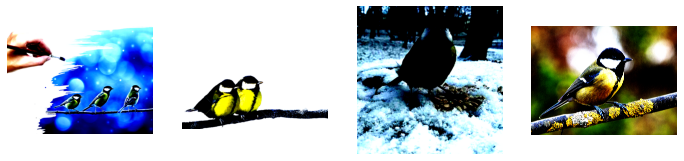

In [ ]:
plot_batch(imgs, boxes, preds=None)

In [ ]:
len(imgs)

4

In [ ]:
path_annotations="/home/costia/birds/annotations/" 
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)

FileNotFoundError: [Errno 2] No such file or directory: '/home/costia/birds/синицы на кормушке_73.xml'

In [ ]:
path_annotations="/home/costia/birds/annotations/" 

os.listdir(path_annotations)

['синицы на снегу_8.xml',
 'синицы на кормушке_18.xml',
 'синицы на кормушке_89.xml',
 'синицы на кормушке_88.xml',
 'синицы на кормушке_29.xml',
 'синицы на кормушке_14.xml',
 'синицы_36.xml',
 'синицы на снегу_85.xml',
 'синицы на снегу_97.xml',
 'синицы на кормушке_91.xml',
 'синицы на кормушке_24.xml',
 'great tits\u3000bird_19.xml',
 'синицы на кормушке_71.xml',
 'синицы_91.xml',
 'синицы на снегу_63.xml',
 'синицы_61.xml',
 'синицы на кормушке_58.xml',
 'синицы на кормушке_56.xml',
 'синицы_6.xml',
 'синицы_65.xml',
 'синицы_88.xml',
 'синицы_41.xml',
 'синицы_11.xml',
 'great tits\u3000bird_64.xml',
 'синицы на снегу_40.xml',
 'синицы_66.xml',
 'синицы_9.xml',
 'синицы_5.xml',
 'синицы_93.xml',
 'great tits\u3000bird_45.xml',
 'синицы_81.xml',
 'синицы_78.xml',
 'синицы на снегу_48.xml',
 'синицы_90.xml',
 'синицы на снегу_41.xml',
 'синицы на кормушке_76.xml',
 'great tits\u3000bird_71.xml',
 'great tits\u3000bird_22.xml',
 'синицы на кормушке_25.xml',
 'great tits\u3000bird_11

In [ ]:
with open(file) as fd:
    doc=xmltodict.parse(fd.read())
temp=doc["annotation"]["object"]

In [ ]:
doc

OrderedDict([('annotation',
              OrderedDict([('folder', 'birds'),
                           ('filename', 'синицы на снегу_8.jpg'),
                           ('path', '/birds/синицы на снегу_8.jpg'),
                           ('source',
                            OrderedDict([('database', 'Unspecified')])),
                           ('size',
                            OrderedDict([('width', '1920'),
                                         ('height', '1200'),
                                         ('depth', '3')])),
                           ('object',
                            OrderedDict([('name', 'blue_tit'),
                                         ('pose', 'Unspecified'),
                                         ('truncated', 'Unspecified'),
                                         ('difficult', 'Unspecified'),
                                         ('bndbox',
                                          OrderedDict([('xmin', '485'),
                            

In [ ]:
img_names=[] 
xml_names=[]

for dirname, _, filenames in os.walk('/home/costia/birds/'):
    for filename in filenames:
        
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [ ]:
file = os.path.join(path_annotations, 'great tits　bird_48.xml')

In [ ]:
import xml.etree.ElementTree as ET


with open(file) as f:
    

In [ ]:
def xml_transform(xml_path):
    xml = ET.parse(xml_path)
    root = xml.getroot()
    img_name = root[1].text
    labels, boxes = [], [] 
    
    for obj in root.iter('object'):
        label = obj[0].text
        labes.append(label)
        box = [int(coord.text) for coord in obj[5]]
        boxes.append(box)
    target = {'boxes' : torch.as_tensor(boxes, dtype=torch.float32),
              'labels' : labels}
    return img_name, target
        

In [ ]:
xml_names

['синицы на снегу_8.xml',
 'синицы на кормушке_18.xml',
 'синицы на кормушке_89.xml',
 'синицы на кормушке_88.xml',
 'синицы на кормушке_29.xml',
 'синицы на кормушке_14.xml',
 'синицы_36.xml',
 'синицы на снегу_85.xml',
 'синицы на снегу_97.xml',
 'синицы на кормушке_91.xml',
 'синицы на кормушке_24.xml',
 'great tits\u3000bird_19.xml',
 'синицы на кормушке_71.xml',
 'синицы_91.xml',
 'синицы на снегу_63.xml',
 'синицы_61.xml',
 'синицы на кормушке_58.xml',
 'синицы на кормушке_56.xml',
 'синицы_6.xml',
 'синицы_65.xml',
 'синицы_88.xml',
 'синицы_41.xml',
 'синицы_11.xml',
 'great tits\u3000bird_64.xml',
 'синицы на снегу_40.xml',
 'синицы_66.xml',
 'синицы_9.xml',
 'синицы_5.xml',
 'синицы_93.xml',
 'great tits\u3000bird_45.xml',
 'синицы_81.xml',
 'синицы_78.xml',
 'синицы на снегу_48.xml',
 'синицы_90.xml',
 'синицы на снегу_41.xml',
 'синицы на кормушке_76.xml',
 'great tits\u3000bird_71.xml',
 'great tits\u3000bird_22.xml',
 'синицы на кормушке_25.xml',
 'great tits\u3000bird_11